In [1]:
import numpy as np
from PIL import Image
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.datasets import *
from tensorflow.keras.preprocessing.image import *

Tensorflow has a great feature where instead of saving large numbers of aumented pictures, tensorflow uses the data generator to augment images as you feed them into the network, the augmentration takes place in memory as you are feeding them in, these images are not saved at any point.

This is a really important tool used to prevent overfitting to a small dataset, so that it is more geenralisable and can help more with future novel images.

this can be imagined as not being flexible in what an image of something can look like

https://github.com/keras-team/keras-preprocessing

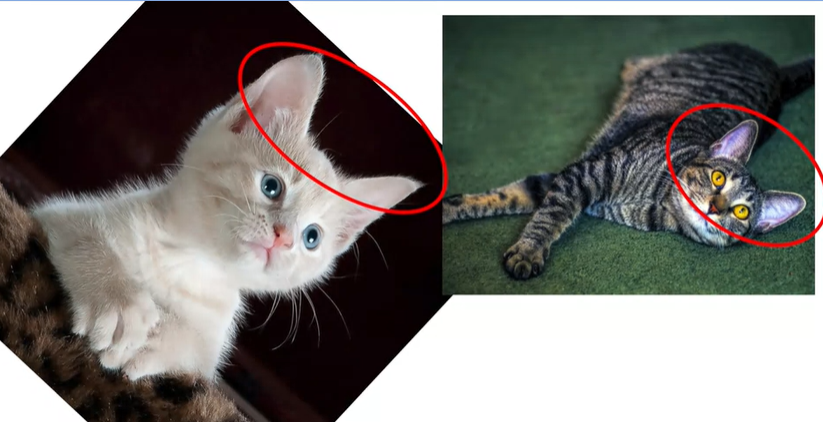

In [28]:
Image.open(r'C:\Users\44788/Desktop\it1.png')

In [2]:
# keras API ImageDataGenerator gives you many options to augment incoming images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, #range 0 -180 degrees by which the images can be randomly rotated
    width_shift_range=0.2, # moves images around inside its frame - specify prop how much sub moved
    height_shift_range=0.2, 
    shear_range=0.2, # shear image random amounts
    zoom_range=0.2, # as can be guessed
    horizontal_flip=True,
    fill_mode='nearest') # fills in missing pixels - might be lost due to augmentation

train_dir = r'C:\Users\44788\Desktop\CatsvsDogs\train'
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 23998 images belonging to 2 classes.


In [3]:
validation_datagen = ImageDataGenerator(rescale=1./255) 
validation_dir = r'C:\Users\44788\Desktop\CatsvsDogs\validation'
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 1002 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255) # rescale the image also
test_dir = r'C:\Users\44788\Desktop\CatsvsDogs\test'
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(150,150),
                                                   batch_size=1,
                                                   class_mode='binary')

#filenames = test_generator.filenames
#nb_samples = len(filenames)
#predict = model.predict_generator(test_generator,steps = nb_samples)

Found 9598 images belonging to 1 classes.


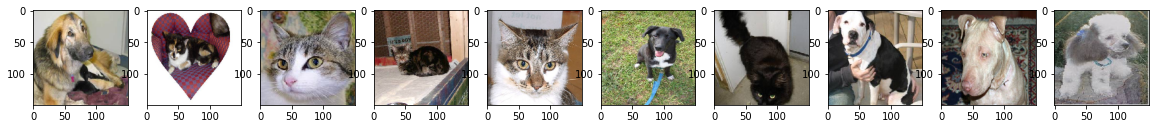

In [37]:
images = train_generator[1]
im = images[1]
fig, ax = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    im = images[0]
    ax[i].imshow(im[i])

In [4]:
def res_net_block(input_data, filters, conv_size):
    x = Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = BatchNormalization()(x)
    x = Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_data])
    x = Activation('relu')(x)
    return x

In [10]:
inputs = Input(shape=(150, 150, 3))
x = Conv2D(16, 3, activation='relu')(inputs)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(3)(x)
num_res_net_blocks = 3

for i in range(num_res_net_blocks):
    x = res_net_block(x, 32, 3)

x = Conv2D(64, 3, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
res_net_model = Model(inputs, outputs)

In [11]:
res_net_model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=0.0001),
             metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001)

checkpoint_path = r'C:\Users\44788\Desktop\CatsvsDogs\CvD2.h5'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                            frequency='epoch',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_accuracy',
                            verbose=0)

In [13]:
history = res_net_model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=50,
                    epochs=100,
                    validation_steps=50,
                    verbose=0,
                    callbacks=[checkpoint, early_stopping])

<AxesSubplot:>

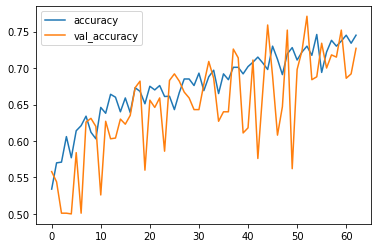

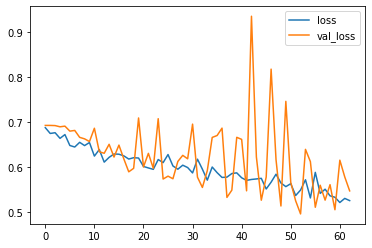

In [14]:
df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])
df.plot(y=['loss', 'val_loss'])